<h1><center><font size="6">Visualizing Albumnetation Transformations Notebook</font></center></h1>

# Contents

- <a href='#1'>Importing Packages and Dataframe</a>  
- <a href='#2'>Assigning Paths</a>
- <a href='#3'>Displaying Melanoma Images</a>
- <a href='#4'>Displaying Non-Melanoma Images</a>   
- <a href='#5'>Albumentations Transformations</a>
    - <a href='#501'>Transpose</a>
    - <a href='#502'>Vertical Flip</a>
    - <a href='#503'>Horizontal Flip</a>
    - <a href='#504'>Random Brightness</a>
    - <a href='#505'>Random Contrast</a>
    - <a href='#506'>CLAHE</a>
    - <a href='#507'>Hue Saturation Value</a>
    - <a href='#508'>Shift Scale Rotate</a>
    - <a href='#509'>Cutout</a>
    - <a href='#510'>Motion Blur</a>
    - <a href='#511'>Median Blur</a>
    - <a href='#512'>Gaussian Blur</a>
    - <a href='#513'>Gaussian Noise</a>
    - <a href='#514'>Optical Distortion</a>
    - <a href='#515'>Grid Distortion</a>
    - <a href='#516'>Elastic Transform</a>
- <a href='#6'>Creating Transformations</a>
- <a href='#7'>First Train-Validation Split</a>
- <a href='#8'>Second Train-Validation Split</a> 



# <a id='1'>Importing Packages and Dataframe</a>

In [1]:
import pandas as pd
import numpy as np
import cv2
from skimage import io
from glob import glob
import os
import pydicom
import matplotlib.pyplot as plt
import albumentations as A
from PIL import Image
from skimage.color import label2rgb

import warnings
warnings.simplefilter("ignore")

In [2]:
# importing dataframe
df = pd.read_csv("../data/tr.csv", index_col=0)
df.head()

,file,patient_id,lesion_id,gender,age,site,diagnosis,ben_mal,target
0,ISIC_0065823,NaN,BCN_0003902,male,75.0,anterior torso,NaN,NaN,1
1,ISIC_0013908_downsampled,NaN,MSK4_0010423,male,75.0,posterior torso,NaN,NaN,1
2,ISIC_0054089,NaN,BCN_0005268,male,45.0,anterior torso,NaN,NaN,1
3,ISIC_0061371,NaN,BCN_0004405,male,60.0,palms/soles,NaN,NaN,1
4,ISIC_8702237,IP_0738123,IL_8854900,female,50.0,lower extremity,melanoma,malignant,1


In [3]:
df = df[['file', 'target']]
df.head()

,file,target
0,ISIC_0065823,1
1,ISIC_0013908_downsampled,1
2,ISIC_0054089,1
3,ISIC_0061371,1
4,ISIC_8702237,1


# <a id='2'>Assigning Paths</a>


In [4]:
# === DICOM ===
# Create the paths
path_tr_dcm = '../split/train_dcm/' + df['file'] + '.dcm'
path_tr_jpg = '../split/train/mel/' + df['file'] + '.jpg'

# Append to the original dataframes
df['path_dcm'] = path_tr_dcm
df['path_jpg'] = path_tr_jpg

In [5]:
df['dcm'] = df.file.apply(lambda x: str(x) + '.dcm')
df['jpg'] = df.file.apply(lambda x: str(x) + '.jpg')

In [6]:
df.head()

,file,target,path_dcm,path_jpg,dcm,jpg
0,ISIC_0065823,1,../split/train_dcm/ISIC_0065823.dcm,../split/train/mel/ISIC_0065823.jpg,ISIC_0065823.dcm,ISIC_0065823.jpg
1,ISIC_0013908_downsampled,1,../split/train_dcm/ISIC_0013908_downsampled.dcm,../split/train/mel/ISIC_0013908_downsampled.jpg,ISIC_0013908_downsampled.dcm,ISIC_0013908_downsampled.jpg
2,ISIC_0054089,1,../split/train_dcm/ISIC_0054089.dcm,../split/train/mel/ISIC_0054089.jpg,ISIC_0054089.dcm,ISIC_0054089.jpg
3,ISIC_0061371,1,../split/train_dcm/ISIC_0061371.dcm,../split/train/mel/ISIC_0061371.jpg,ISIC_0061371.dcm,ISIC_0061371.jpg
4,ISIC_8702237,1,../split/train_dcm/ISIC_8702237.dcm,../split/train/mel/ISIC_8702237.jpg,ISIC_8702237.dcm,ISIC_8702237.jpg


# <a id='3'>Displaying Melanoma Images</a>


In [1]:
# display sample of melanoma images
plt.style.use('seaborn')
paths = glob('../split/train/mel/*.jpg')
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(16,6))
plt.suptitle('Melanoma Images', fontsize=16)
for i in range(0, 15):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    x = i // 5
    y = i % 5
    axes[x, y].imshow(image, cmap=plt.cm.bone)
    axes[x, y].axis('off')
    

<img src="../images/melanoma_images.png">

# <a id='4'>Displaying Non-Melanoma Images</a>


In [2]:
# display sample of non-melanoma images
paths = glob('../split/train/not_mel/*.jpg')
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(16,6))
plt.suptitle('Non-Melanoma Images', fontsize=16)
for i in range(0, 15):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    x = i // 5
    y = i % 5
    axes[x, y].imshow(image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

<img src="../images/non_melanoma_images.png">

# <a id='5'>Albumentations Transformations</a>


## <a id='501'>Transpose</a>


In [64]:
# display Transpose augmentations (rotates image by )
transform = A.Compose([
    A.Transpose()
])

paths = glob('../split/train/mel/*.jpg')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 6))
plt.suptitle('Transpose', fontsize=16)
for i in range(0, 10):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))
    transformed = transform(image=image)
    aug_image = transformed['image']
    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

<img src="../images/transpose.png">

## <a id='502'>Vertical Flip</a>


In [63]:
# display Vertical Flip augmentations
transform = A.Compose([
    A.VerticalFlip()
])
paths = glob('../split/train/mel/*.jpg')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 6))
plt.suptitle('VerticalFlip', fontsize=16)
for i in range(0, 10):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))
    transformed = transform(image=image)
    aug_image = transformed['image']
    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

<img src="../images/vertical_flip.png">

## <a id='503'>Horizontal Flip</a>


In [62]:
# display Horizontal Flip augmentations
transform = A.Compose([
    A.HorizontalFlip()
])

paths = glob('../split/train/mel/*.jpg')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('HorizontalFlip', fontsize=16)
for i in range(0, 10):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']
   
    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

<img src="../images/horizontal_flip.png">

## <a id='504'>Random Brightness</a>


In [61]:
# display Random Brightness augmentations
transform = A.Compose([
    A.RandomBrightness(limit=0.3)
])

paths = glob('../split/train/mel/*.jpg')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('RandomBrightness', fontsize=16)
for i in range(0, 10):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']
   
    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

<img src="../images/random_brightness.png">

## <a id='505'>Random Contrast</a>


In [60]:
# display Random Contrast augmentations
transform = A.Compose([
    A.RandomContrast(limit=0.3)
])

paths = glob('../split/train/mel/*.jpg')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('RandomContrast', fontsize=16)
for i in range(0, 10):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']
   
    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

<img src="../images/random_contrast.png">

## <a id='506'>CLAHE</a>


In [59]:
# display CLAHE augmentations
transform = A.Compose([
    A.CLAHE(clip_limit=6.0)
])

paths = glob('../split/train/mel/*.jpg')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('CLAHE', fontsize=16)
for i in range(0, 10):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']
   
    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

<img src="../images/clahe.png">

## <a id='507'>Hue Saturation Value</a>


In [49]:
# display Hue Saturation Value augmentations
transform = A.Compose([
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10)
])

paths = glob('../split/train/mel/*.jpg')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('HueSaturationValue', fontsize=16)
for i in range(0, 10):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']
   
    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

<img src="../images/hue_saturation_value.png">

## <a id='508'>Shift Scale Rotate</a>


In [58]:
# display Shift Scale Rotate augmentations
transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, border_mode=0)
])

paths = glob('../split/train/mel/*.jpg')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('ShiftScaleRotate', fontsize=16)
for i in range(0, 10):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']
   
    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

<img src="../images/shift_scale_rotate.png">

## <a id='509'>Cutout</a>


In [57]:
# display Cutout augmentations
image_size = 128

transform = A.Compose([
    A.Cutout(max_h_size=32, max_w_size=32, num_holes=8)
])

paths = glob('../split/train/mel/*.jpg')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('Cutout', fontsize=16)
for i in range(0, 10):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']
   
    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

<img src="../images/cutout.png">

## <a id='510'>Motion Blur</a>

In [56]:
# display Motion Blur augmentations
transform = A.Compose([
    A.MotionBlur(blur_limit=5)
])

paths = glob('../split/train/mel/*.jpg')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('MotionBlur', fontsize=16)
for i in range(0, 10):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']
    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

<img src="../images/motion_blur.png">

## <a id='511'>Median Blur</a>


In [55]:
# display Median Blur augmentations
transform = A.Compose([
    A.MedianBlur(blur_limit=7)
])

paths = glob('../split/train/mel/*.jpg')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('MedianBlur', fontsize=16)
for i in range(0, 10):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']
   
    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

<img src="../images/median_blur.png">

## <a id='512'>Gaussian Blur</a>


In [54]:
# display Gaussian Blur augmentations
transform = A.Compose([
    A.GaussianBlur(blur_limit=7)
])

paths = glob('../split/train/mel/*.jpg')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('GaussianBlur', fontsize=16)
for i in range(0, 10):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']
   
    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

<img src="../images/gaussian_blur.png">

## <a id='513'>Gaussian Noise</a>

In [53]:
# display Gaussian Noise augmentations
transform = A.Compose([
    A.GaussNoise(var_limit=(5.0, 30.0))
])

paths = glob('../split/train/mel/*.jpg')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('GaussNoise', fontsize=16)
for i in range(0, 10):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']
   
    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

<img src="../images/gauss_noise.png">

## <a id='513'>Optical Distortion</a>


In [50]:
# display Optical Distortion augmentations
transform = A.Compose([
    A.OpticalDistortion(distort_limit=1.0)
])

paths = glob('../split/train/mel/*.jpg')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('OpticalDistortion', fontsize=16)
for i in range(0, 10):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']
   
    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

<img src="../images/optical_distortion.png">

## <a id='514'>Grid Distortion</a>

In [51]:
# display Grid Distortion augmentations
transform = A.Compose([
    A.GridDistortion(num_steps=5, distort_limit=1.0)
])

paths = glob('../split/train/mel/*.jpg')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('GridDistortion', fontsize=16)
for i in range(0, 10):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']
   
    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

<img src="../images/grid_distortion.png">

## <a id='514'>Elastic Transform</a>

In [52]:
# display Elastic Transform augmentations
transform = A.Compose([
    A.ElasticTransform(alpha=3)
])

paths = glob('../split/train/mel/*.jpg')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 6))
plt.suptitle('ElasticTransform', fontsize=16)
for i in range(0, 10):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']
   
    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

<img src="../images/elastic_transform.png">

# Creating Transformations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

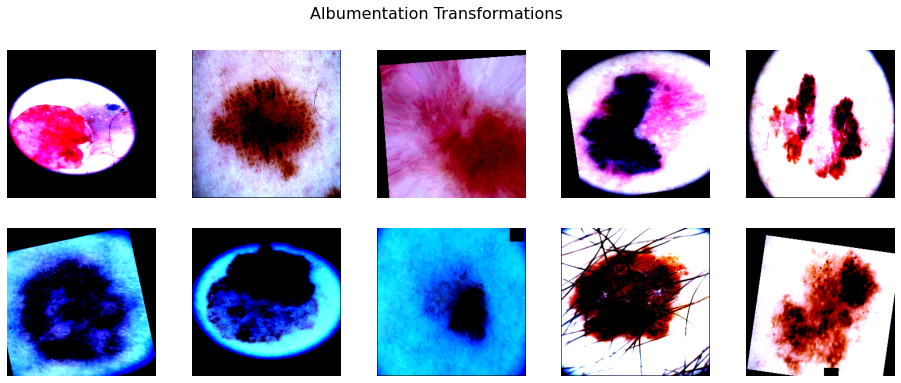

In [19]:
# defining augmentation pipeline
transform = A.Compose([
    A.Transpose(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightness(limit=0.2, p=0.5),
    A.RandomContrast(limit=0.2, p=0.1),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=0.1),
    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.0),
        A.ElasticTransform(alpha=3),
    ], p=0.1),
    A.CLAHE(clip_limit=4.0, p=0.1),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.1),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.4),
    A.Resize(256, 256),
    A.Cutout(max_h_size=int(256 * 0.1), max_w_size=int(256 * 0.1), num_holes=1, p=0.2),
    A.Normalize()
])

paths = glob('../split/train/mel/*.jpg')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('Albumentation Transformations', fontsize=16)
for i in range(0, 10):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']
   
    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image, cmap=plt.cm.bone)
    axes[x, y].axis('off')


# First Train-Validation Split

In [29]:
# paths = glob('../split/train/mel/2020/*.jpg')


# for i in range(0, 467):   
#     f, ax = plt.subplots()
#     image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     transformed = transform(image=image)
#     aug_image = transformed['image']
#     plt.imshow(aug_image)
#     plt.savefig("../split/train/mel/2020_T/aug_image_{}.png".format(i))
#     plt.close('all')

In [35]:
# paths = glob('../split/train/mel/2019/*.jpg')

# for i in tqdm(range(0, 4522)):   
#     f, ax = plt.subplots()
#     image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     transformed = transform(image=image)
#     aug_image = transformed['image']
#     plt.imshow(aug_image)
#     plt.savefig("../split/train/mel/2019_T/aug_image_{}.png".format(i))
#     plt.close('all')

In [36]:
# paths = glob('../split/train/mel/2018/*.jpg')

# for i in range(0, 1113):   
#     f, ax = plt.subplots()
#     image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     transformed = transform(image=image)
#     aug_image = transformed['image']
#     plt.imshow(aug_image)
#     plt.savefig("../split/train/mel/2018_T/aug_image_{}.png".format(i))
#     plt.close('all')

# Second Train-Validation Split

In [8]:
paths = glob('../split/train/mel/*.jpg')


for i in range(0, 4084):   
    f, ax = plt.subplots()
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transformed = transform(image=image)
    aug_image = transformed['image']
    plt.imshow(aug_image)
    plt.savefig("../split/train/mel/aug/aug_image_{}.jpg".format(i))
    plt.close('all')

to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the val

In [9]:
paths = glob('../sample/train/mel/*.jpg')


for i in range(0, 817):   
    f, ax = plt.subplots()
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transformed = transform(image=image)
    aug_image = transformed['image']
    plt.imshow(aug_image)
    plt.savefig("../sample/train/mel/aug/aug_image_{}.png".format(i))
    plt.close('all')

to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the val